In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import mode

In [2]:
df = pd.read_excel('Data_Train.xlsx')

In [3]:
df.sample(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
4544,Jet Airways,24/03/2019,Kolkata,Banglore,CCU → BOM → BLR,21:10,08:10 25 Mar,11h,1 stop,No info,14231
8956,IndiGo,12/06/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,4226
847,IndiGo,18/06/2019,Banglore,Delhi,BLR → DEL,05:30,08:20,2h 50m,non-stop,No info,3943
6644,Jet Airways,09/03/2019,Banglore,New Delhi,BLR → DEL,19:55,22:35,2h 40m,non-stop,No info,7229
4880,IndiGo,27/03/2019,Delhi,Cochin,DEL → BOM → COK,07:30,13:20,5h 50m,1 stop,No info,8227
3704,Jet Airways,15/05/2019,Kolkata,Banglore,CCU → BOM → BLR,18:55,08:15 16 May,13h 20m,1 stop,In-flight meal not included,9663
5111,IndiGo,9/05/2019,Kolkata,Banglore,CCU → BLR,20:20,22:55,2h 35m,non-stop,No info,4804
5584,SpiceJet,1/05/2019,Chennai,Kolkata,MAA → CCU,08:20,10:35,2h 15m,non-stop,No info,3597
5589,Jet Airways,1/06/2019,Delhi,Cochin,DEL → BOM → COK,21:50,12:35 02 Jun,14h 45m,1 stop,No info,14714
7786,IndiGo,15/06/2019,Chennai,Kolkata,MAA → CCU,14:45,17:05,2h 20m,non-stop,No info,3597


In [4]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
df.shape

(10683, 11)

In [7]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [8]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Journey_day']=df['Date_of_Journey'].dt.day
df['Journey_month']=df['Date_of_Journey'].dt.month
df["Journey_year"]=df['Date_of_Journey'].dt.year
df.drop(columns=['Date_of_Journey'], inplace=True)

In [9]:
df['Source'].value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

In [10]:
df['Destination'].value_counts()

Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [11]:
df.drop(columns='Route', inplace=True)

In [12]:
df.columns

Index(['Airline', 'Source', 'Destination', 'Dep_Time', 'Arrival_Time',
       'Duration', 'Total_Stops', 'Additional_Info', 'Price', 'Journey_day',
       'Journey_month', 'Journey_year'],
      dtype='object')

In [13]:
df['Dep_Time']=pd.to_datetime(df['Dep_Time'], format='%H:%M')
df['Dep_total_time']=df['Dep_Time'].dt.minute+ (df['Dep_Time'].dt.hour * 60)
df.drop(columns=['Dep_Time'], inplace=True)

In [14]:
df['Arrival_Time']=df['Arrival_Time'].str.extract(r'(\d{2}:\d{2})')[0]
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M')
df['Arrival_total_time']=df['Arrival_Time'].dt.minute + (df['Arrival_Time'].dt.hour * 60)
df.drop(columns=['Arrival_Time'], inplace=True)

In [15]:
duration=df['Duration'].str.extract(r'(?:(\d+)h)?\s*(?:(\d+)m)?')
duration_hr=duration[0].fillna(0).astype(int)
duration_min=duration[1].fillna(0).astype(int)
df['Duration_total_time'] = duration_hr * 60 + duration_min
df.drop(columns=['Duration'], inplace=True)

In [16]:
df['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [17]:
stop_map={
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}

df['Total_Stops']=df['Total_Stops'].map(stop_map)
df['Total_Stops']=df['Total_Stops'].fillna(0).astype(int)

In [18]:
df.drop(columns=['Additional_Info'], inplace=True)

In [19]:
df['Price'] = df['Price'].fillna(df['Price'].median())

In [20]:
df.sample(10)

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Journey_year,Dep_total_time,Arrival_total_time,Duration_total_time
3478,Vistara,Kolkata,Banglore,1,8610,6,6,2019,1020,1405,385
5115,Vistara,Kolkata,Banglore,1,7980,1,4,2019,430,545,1555
6050,Jet Airways,Banglore,Delhi,0,7229,12,4,2019,500,680,180
1692,Jet Airways,Kolkata,Banglore,1,13626,12,6,2019,845,1415,570
5363,Air India,Delhi,Cochin,2,8236,21,3,2019,1185,1155,1410
3810,Vistara,Banglore,Delhi,0,4668,21,5,2019,585,755,170
507,IndiGo,Chennai,Kolkata,0,3540,9,5,2019,315,460,145
6402,Air India,Delhi,Cochin,1,12677,6,3,2019,1240,565,765
549,Air India,Kolkata,Banglore,1,11096,21,5,2019,420,1225,805
10554,Jet Airways,Delhi,Cochin,2,10368,6,6,2019,330,1140,810


In [21]:
df=pd.get_dummies(df,columns=['Airline', 'Source', 'Destination'], drop_first=True)

In [22]:
df.head()

,Total_Stops,Price,Journey_day,Journey_month,Journey_year,Dep_total_time,Arrival_total_time,Duration_total_time,Airline_Air India,Airline_GoAir,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,2019,1340,70,170,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2,7662,1,5,2019,350,795,445,True,False,...,False,False,False,True,False,False,False,False,False,False
2,2,13882,9,6,2019,565,265,1140,False,False,...,False,False,True,False,False,True,False,False,False,False
3,1,6218,12,5,2019,1085,1410,325,False,False,...,False,False,False,True,False,False,False,False,False,False
4,1,13302,1,3,2019,1010,1295,285,False,False,...,False,False,False,False,False,False,False,False,False,True


In [23]:
X=df.drop(columns=['Price'])
y=df['Price']

In [24]:
def preprocess_flight_data(df, is_train=True):
    import pandas as pd
    import numpy as np

    df = df.copy()  # Avoid modifying original

    # 1. Date
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True)
    df['Journey_day'] = df['Date_of_Journey'].dt.day
    df['Journey_month'] = df['Date_of_Journey'].dt.month
    df['Journey_year'] = df['Date_of_Journey'].dt.year
    df.drop(columns='Date_of_Journey', inplace=True)

    # 2. Dep Time
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])
    df['Dep_total_time'] = df['Dep_Time'].dt.hour * 60 + df['Dep_Time'].dt.minute
    df.drop(columns='Dep_Time', inplace=True)

    # 3. Arrival Time
    df['Arrival_Time'] = df['Arrival_Time'].str.extract(r'(\d{2}:\d{2})')[0]
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M')
    df['Arrival_total_time'] = df['Arrival_Time'].dt.hour * 60 + df['Arrival_Time'].dt.minute
    df.drop(columns='Arrival_Time', inplace=True)

    # 4. Duration
    duration_split = df['Duration'].str.extract(r'(?:(\d+)h)? ?(?:(\d+)m)?')
    hours = duration_split[0].fillna(0).astype(int)
    minutes = duration_split[1].fillna(0).astype(int)
    df['Duration_total_time'] = hours * 60 + minutes
    df.drop(columns='Duration', inplace=True)

    # 5. Total Stops
    stop_map = {'non-stop': 0, '1 stop': 1, '2 stop': 2, '3 stop': 3, '4 stop': 4}
    df['Total_Stops'] = df['Total_Stops'].map(stop_map).fillna(1).astype(int)

    # 6. Drop useless
    df.drop(columns=['Route', 'Additional_Info'], inplace=True)

    # 7. Encode
    df = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination'], prefix=['Airline', 'Source', 'Dest'], drop_first=True)

    # 8. For test data: align with training columns
    if not is_train:
        # Ensure test set has same columns as train (X should already exist)
        missing_cols = set(X.columns) - set(df.columns)
        for col in missing_cols:
            df[col] = 0
        df = df[X.columns]  # reorder

    return df


In [25]:
df_test=pd.read_excel('Test_set.xlsx')

In [26]:
df_test_cleaned = preprocess_flight_data(df_test, is_train=False)


C:\Users\YUG CHAUHAN\AppData\Local\Temp\ipykernel_14368\626079217.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])


In [27]:
df_test_cleaned

,Total_Stops,Journey_day,Journey_month,Journey_year,Dep_total_time,Arrival_total_time,Duration_total_time,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,2019,1050,265,655,False,False,False,...,False,False,True,False,False,0,0,0,0,0
1,1,12,5,2019,380,620,240,False,False,True,...,False,False,False,True,False,0,0,0,0,0
2,1,21,5,2019,1155,1140,1425,False,False,False,...,False,False,True,False,False,0,0,0,0,0
3,1,21,5,2019,480,1260,780,False,False,False,...,False,False,True,False,False,0,0,0,0,0
4,0,24,6,2019,1435,165,170,False,False,False,...,False,False,False,False,False,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,6,6,2019,1230,1225,1435,True,False,False,...,False,False,False,True,False,0,0,0,0,0
2667,0,27,3,2019,860,1015,155,False,False,True,...,False,False,False,True,False,0,0,0,0,0
2668,1,6,3,2019,1310,265,395,False,False,False,...,False,False,True,False,False,0,0,0,0,0
2669,1,6,3,2019,240,1155,915,True,False,False,...,False,False,True,False,False,0,0,0,0,0


In [28]:
X.head()

,Total_Stops,Journey_day,Journey_month,Journey_year,Dep_total_time,Arrival_total_time,Duration_total_time,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,2019,1340,70,170,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,2,1,5,2019,350,795,445,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2,9,6,2019,565,265,1140,False,False,False,...,False,False,True,False,False,True,False,False,False,False
3,1,12,5,2019,1085,1410,325,False,False,True,...,False,False,False,True,False,False,False,False,False,False
4,1,1,3,2019,1010,1295,285,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
rf=RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [113]:
y_pred=rf.predict(X_test)

In [114]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae= mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2_score= r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2_score}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Mean Absolute Error: 1195.4503160446507
Mean Squared Error: 4258368.548649807
R^2 Score: 0.7987915621558592
Root Mean Squared Error: 2063.5814858274452


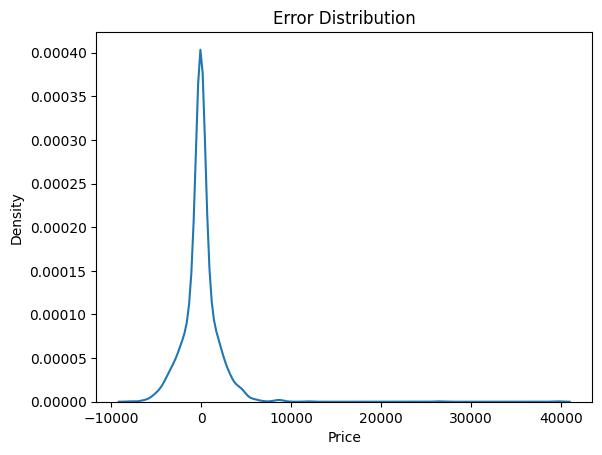

In [118]:
sns.kdeplot(y_test- y_pred)
plt.title("Error Distribution")
plt.show()

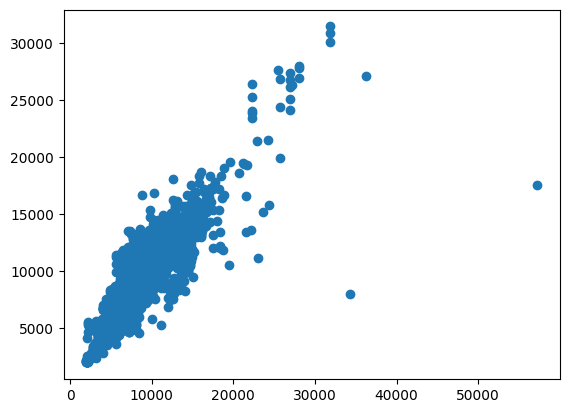

In [119]:
plt.scatter(y_test, y_pred)

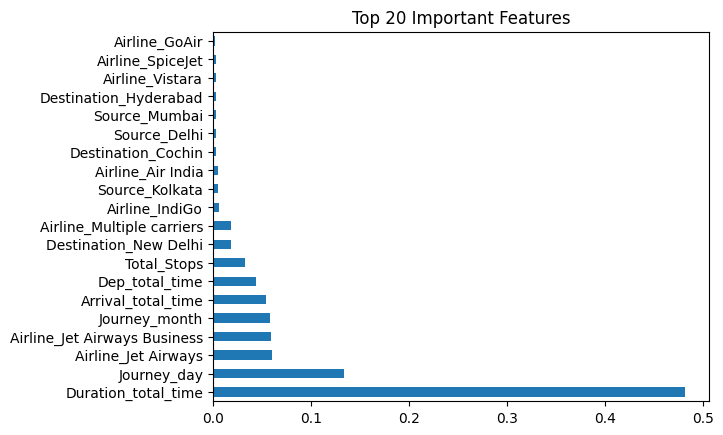

In [120]:
import pandas as pd

feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(20).plot(kind='barh')
plt.title("Top 20 Important Features")
plt.show()


In [122]:
from sklearn.model_selection import RandomizedSearchCV
random_grid= {
    'n_estimators': [int(x) for x in np.linspace(100,1200,12)],
    'max_features': [None, 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(5,30,6)],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    scoring='neg_mean_squared_error',
    n_iter=10,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [123]:
best_params

{'n_estimators': 300,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 30,
 'bootstrap': False}

In [125]:
from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=20,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    bootstrap=False,
    random_state=42
)

best_rf.fit(X, y)


RandomForestRegressor(bootstrap=False, max_depth=30, max_features=None,
                      min_samples_leaf=2, min_samples_split=20,
                      n_estimators=300, random_state=42)

In [126]:
y_pred= best_rf.predict(X_test)

In [135]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')    
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Mean Absolute Error: 913.0120584169088
Mean Squared Error: 2137380.174182882
R^2 Score: 0.8990085238012728
Root Mean Squared Error: 1461.9781715822169


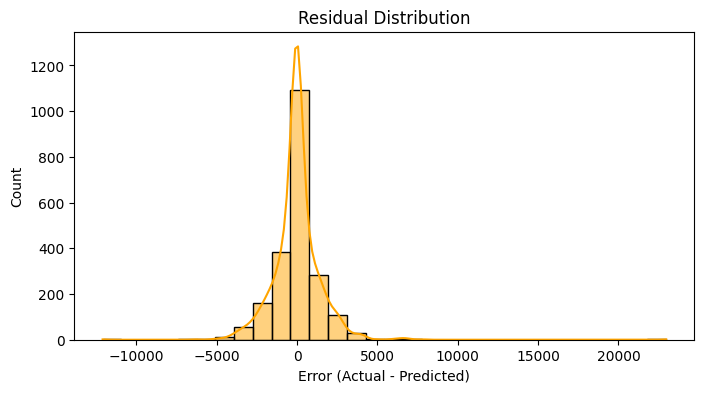

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals =  y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=30, color="orange")
plt.title("Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.show()


In [139]:
relative_errors = (abs(y_test - y_pred) / y_test) * 100
print("Mean % Error:", np.mean(relative_errors))

Mean % Error: 10.116581403902488


In [141]:
import pickle

# Save model
with open("final_rf_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

print("✅ Model saved as 'final_rf_model.pkl'")

✅ Model saved as 'final_rf_model.pkl'


In [142]:
import pickle

# After training
with open("X_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)